In [21]:
## inaguaral pybaseball notebook !! 
#imports
from pybaseball import statcast
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import playerid_lookup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import logging
import polars as pl
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
%matplotlib inline

In [2]:
logging.basicConfig(
        filename='zachwheeler.log',
        level=logging.DEBUG, 
        format='%(asctime)s - %(levelname)s - %(message)s',
        filemode='a' # Use 'a' for append (default), or 'w' for overwrite
    )
logger= logging.getLogger(__name__)

In [3]:
#find playerid lookup of zack wheeler
pitcher= playerid_lookup("wheeler","zack")
pitcherid = pitcher.loc[0,"key_mlbam"]
pitcherid = float(pitcherid)
#pull zack wheeler's pitch data from the 2020 to 2025 seasons
wheeler_pitches = statcast_pitcher('2020-04-02', '2025-10-09', pitcherid)
logger.info(f"number of pitches found: {wheeler_pitches.shape[0]}")

Gathering player lookup table. This may take a moment.
Gathering Player Data


In [4]:
#convert wheeler_pitches from pandas dataframe to polars dataframe
wheeler_pitches = pl.from_pandas(wheeler_pitches)
#create new column which is the unique ID of the at bat
wheeler_pitches = wheeler_pitches.with_columns(
    pl.concat_str([pl.col("game_pk").cast(pl.Utf8), pl.lit("_"), pl.col("at_bat_number").cast(pl.Utf8)]).alias("ab_id")
)


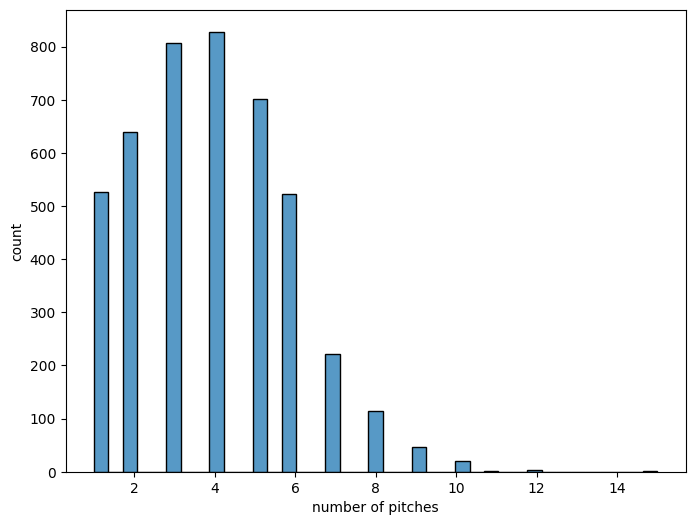

In [5]:
#count unique number of ab_ids so that we can have an idea of how much data we should have
abs = wheeler_pitches["ab_id"].n_unique()
logger.info(f"there are {abs} at-bats in these data")

#plot the distribution of pitches per at bat id
grouped_counts = wheeler_pitches.group_by("ab_id").agg(
    pl.count("ab_id").alias("pitch_count")
)
# print a histogram of the pitch_count column of grouped_counts
plt.figure(figsize=(8,6))
sns.histplot(data=grouped_counts, x="pitch_count")
plt.xlabel("number of pitches")
plt.ylabel("count")
plt.show()

In [6]:
# pitch tunneling, for Zack's most common pitch combinations, what is the most location differential to maximize deception?
#identify two pitch sequences that he uses within at-bats, might want to use the one that gives you a whiff or contact on
#the last pitch of the at bat
# Create a column with the next pitch type in the at-bat
pitch_sequences = wheeler_pitches.with_columns(
    next_pitch_type=pl.col("pitch_type").shift(-1).over("ab_id", order_by="pitch_number")
)


# Filter out the last pitch of each at-bat (where next_pitch_type is null)
pitch_sequences = pitch_sequences.filter(pl.col('next_pitch_type').is_not_null())

# Create a sequence label
pitch_sequences = pitch_sequences.with_columns(
    sequence = pl.concat_str([
        pl.col('pitch_type'),
        pl.lit('-'),
        pl.col('next_pitch_type')
    ])
)

# Count each two-pitch sequence
sequence_counts = pitch_sequences.group_by('sequence').agg(
    pl.count().alias('count')
).sort('count', descending=True)
logger.info(f"most common pitch sequences:\n{sequence_counts.head(10)}")

In [7]:
#filter by the last or second to last pitches in a given at bat
lastpitches = wheeler_pitches.with_columns(
    max_pitch = pl.col("pitch_number").max().over("ab_id")
).filter(
    (pl.col("pitch_number") == pl.col("max_pitch")) |
    (pl.col("pitch_number") == (pl.col("max_pitch") - 1))
).drop("max_pitch").sort(["ab_id", "pitch_number"])

logger.info(f"there are {lastpitches.shape[0]} last pitches in these data")

In [8]:
#calculate the percent of the total that is each of these rows
sequence_counts = sequence_counts.with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("pc_oftotal")
)

# keep only top 5 most frequent two-pitch sequences
top5_sequences = sequence_counts.sort('count', descending=True).head(5)
top5_sequences
#remember these sequences later for the optimizer
unique_sequences = top5_sequences["sequence"].to_list()

statcast pitch type documentation is listed here https://baseballsavant.mlb.com/csv-docs#:~:text=The%20documentation%20for%20Statcast%20Search%20CSV%20data,measured%20in%20feet%20from%20the%20catcher's%20perspective

ok, so let's think about what we want to optimize on
we want to maximize strikeouts obviously, minimize hits, and minimize walks

In [9]:
#count the number of each unique events column entry in lastpitches
event_counts = lastpitches.group_by("events").agg(
    pl.count().alias("count")
).sort("count", descending=True)
logger.info(f"most common events in last pitches:\n{event_counts.head(10)}")

In [10]:
# NEW APPROACH: Use description instead of events to get much more data
# This looks at ALL two-pitch sequences, not just ones that end at-bats
sequences = wheeler_pitches.lazy().sort(['ab_id', 'pitch_number']).with_columns([
    # Get next pitch info (shift -1 to look forward)
    pl.col('pitch_type').shift(-1).over('ab_id').alias('next_pitch_type'),
    pl.col('plate_x').shift(-1).over('ab_id').alias('next_plate_x'),
    pl.col('plate_z').shift(-1).over('ab_id').alias('next_plate_z'),
    pl.col('release_speed').shift(-1).over('ab_id').alias('next_release_speed'),
    pl.col('description').shift(-1).over('ab_id').alias('next_description'),
    pl.col('estimated_woba_using_speedangle').shift(-1).over('ab_id').alias('next_xwoba'),
]).filter(
    # Only keep rows where there IS a next pitch (not the last pitch of at-bat)
    pl.col('next_pitch_type').is_not_null()
).with_columns([
    # Calculate deltas FROM current pitch TO next pitch
    (pl.col('next_plate_x') - pl.col('plate_x')).alias('delta_plate_x'),
    (pl.col('next_plate_z') - pl.col('plate_z')).alias('delta_plate_z'),
    (pl.col('next_release_speed') - pl.col('release_speed')).alias('delta_velocity'),
])

# Collect to see results
sequences_df = sequences.collect()

logger.info(f"Total pitch sequences: {len(sequences_df)}")
logger.info(f"OLD approach would have had: ~1800 sequences (only at-bat ending pitches)")
logger.info(f"NEW approach has: {len(sequences_df)} sequences (all consecutive pitches!)")

In [11]:
# Create a pitch sequence label
# Now using current pitch -> next pitch (instead of first -> current)
sequences_df = sequences_df.with_columns(
    pitch_sequence = pl.concat_str([
        pl.col('pitch_type'),
        pl.lit('-'),
        pl.col('next_pitch_type')
    ])
)

# Show some stats about the description column (our new outcome metric)
description_counts = sequences_df.group_by('next_description').agg(
    pl.count().alias('count')
).sort('count', descending=True)

logger.info(f"Most common outcomes (next_description):\n{description_counts.head(15)}")
sequences_df.head()

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,ab_id,next_pitch_type,next_plate_x,next_plate_z,next_release_speed,next_description,next_xwoba,delta_plate_x,delta_plate_z,delta_velocity,pitch_sequence
str,str,f64,f64,f64,str,i64,i64,str,str,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,f64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,…,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,str
"""CU""","""2020-08-22""",78.5,-1.53,6.0,"""Wheeler, Zack""",594807,554430,null,"""called_strike""",null,null,null,null,2.0,"""Called Strike""","""R""","""R""","""R""","""ATL""","""PHI""","""S""",null,null,0,0,2020,0.86,-0.88,0.04,2.87,null,null,null,0,2,"""Bot""",…,null,0.046,null,-2,-2,0.341,0.341,30,31,30,32,1,0,6.0,1.0,6.0,1.0,4.54,-0.86,-0.86,38.1,null,null,null,null,null,"""630338_13""","""SI""",-0.17,2.38,97.2,"""hit_into_play""",0.06,-0.21,-0.49,18.7,"""CU-SI"""
"""FF""","""2020-08-22""",97.1,-1.45,5.81,"""Wheeler, Zack""",571431,554430,null,"""ball""",null,null,null,null,14.0,"""Ball""","""R""","""L""","""R""","""ATL""","""PHI""","""B""",null,null,0,0,2020,-0.15,0.99,1.28,2.54,null,null,null,1,2,"""Bot""",…,null,-0.042,null,-2,-2,0.317,0.317,30,31,30,32,1,0,6.0,4.0,6.0,1.0,1.4,0.15,-0.15,39.8,null,null,null,null,null,"""630338_14""","""FF""",1.37,3.02,97.6,"""ball""",null,0.09,0.48,0.5,"""FF-FF"""
"""FF""","""2020-08-22""",97.6,-1.47,5.74,"""Wheeler, Zack""",571431,554430,null,"""ball""",null,null,null,null,12.0,"""Ball""","""R""","""L""","""R""","""ATL""","""PHI""","""B""",null,null,1,0,2020,-0.42,1.02,1.37,3.02,null,null,null,1,2,"""Bot""",…,null,-0.063,null,-2,-2,0.32,0.32,30,31,30,32,1,0,6.0,4.0,6.0,1.0,1.35,0.42,-0.42,38.8,null,null,null,null,null,"""630338_14""","""FF""",0.89,2.28,97.8,"""hit_into_play""",0.614,-0.48,-0.74,0.2,"""FF-FF"""
"""SI""","""2020-08-22""",97.2,-1.43,5.71,"""Wheeler, Zack""",663586,554430,null,"""ball""",null,null,null,null,11.0,"""Ball""","""R""","""R""","""R""","""ATL""","""PHI""","""B""",null,null,0,0,2020,-0.99,1.0,-1.64,3.44,null,null,571431.0,1,2,"""Bot""",…,null,-0.026,null,-2,-2,0.344,0.344,30,23,30,23,1,0,6.0,1.0,6.0,1.0,1.38,0.99,0.99,38.5,null,null,null,null,null,"""630338_15""","""SI""",-1.28,3.29,97.3,"""ball""",null,0.36,-0.15,0.1,"""SI-SI"""
"""SI""","""2020-08-22""",97.3,-1.48,5.63,"""Wheeler, Zack""",663586,554430,null,"""ball""",null,null,null,null,11.0,"""Ball""","""R""","""R""","""R""","""ATL""","""PHI""","""B""",null,null,1,0,2020,-1.21,0.88,-1.28,3.29,null,null,571431.0,1,2,"""Bot""",…,null,-0.062,null,-2,-2,0.348,0.348,30,23,30,23,1,0,6.0,1.0,6.0,1.0,1.5,1.21,1.21,35.5,null,null,null,null,null,"""630338_15""","""SI""",-0.5,1.68,98.1,"""foul""",null,0.78,-1.61,0.8,"""SI-SI"""


In [12]:
def get_matching_sequences(params, sequences_df, tolerances):
    """
    Find matching sequences in your data for search.
    
    Parameters:
    ----------
    params : list/tuple
        params = [delta_plate_x, delta_plate_z, delta_velocity, pitch_sequence]
    sequences_df : polars DataFrame
        DataFrame containing pitch sequences with delta columns.
    tolerances : list/tuple
        Tolerances for each delta parameter.
        tolerances = [tol_x, tol_z, tol_velocity]
    
    Returns:
    -------
    polars DataFrame
        Filtered DataFrame with matching sequences.
    """
    logging.info("Searching for matching sequences...")

    delta_x, delta_z, delta_velocity = params
    tol_x, tol_z, tol_velocity = tolerances
    logging.info(f"Parameters: delta_x={delta_x}, delta_z={delta_z}, delta_velocity={delta_velocity}")
    logging.info(f"Tolerances: tol_x={tol_x}, tol_z={tol_z}, tol_velocity={tol_velocity}")
    # Filter to sequences that are close enough to the parameters
    # KEY FIX: Add parentheses around EACH comparison
    matching = sequences_df.filter(
        ((pl.col('delta_plate_x') - delta_x).abs() < tol_x) &
        ((pl.col('delta_plate_z') - delta_z).abs() < tol_z) &
        ((pl.col('delta_velocity') - delta_velocity).abs() < tol_velocity)
    )
    logger.info(f"Found {matching.shape[0]} matching sequences for params: {params}")
    return matching

In [ ]:
############################################################################
# COST FUNCTION - TUNE WEIGHTS HERE
############################################################################
# This is where you can adjust how the optimizer evaluates pitch sequences.
# The cost function determines what makes a "good" pitch sequence.
#
# Lower cost = better for pitcher
# 
# Current weights:
# - Good outcomes (strikes/whiffs): -0.5 (reward)
# - Bad outcomes (balls): +0.3 (penalty)
# - Contact quality (xwOBA): +0.3 (penalty for hard contact)
#
# Adjust these weights to change optimization priorities!
############################################################################

def cost_function_description_based(params, sequences_df, tolerances):
    """
    Cost function based on pitch descriptions (outcomes).
    Optimizes for good pitcher outcomes: whiffs, called strikes, weak contact.
    
    Parameters:
    ----------
    params : list/tuple
        [delta_plate_x, delta_plate_z, delta_velocity]
    sequences_df : polars DataFrame
        Your pitch sequences data (with next_description column)
    tolerances : list/tuple
        [tol_x, tol_z, tol_velocity]
    
    Returns:
    -------
    float
        Cost value (lower is better for the pitcher)
    """
    # Get matching sequences
    matching = get_matching_sequences(params, sequences_df, tolerances)
    logging.info(f"Number of matching sequences used: {len(matching)}")
    
    if len(matching) < 5:
        return 0.5  # Penalty for sparse regions
    
    # Categorize outcomes for the NEXT pitch (the second pitch in the sequence)
    # Good outcomes for pitcher (we want to maximize these)
    good_outcomes = matching.filter(pl.col('next_description').is_in([
        'swinging_strike',
        'swinging_strike_blocked',
        'called_strike',
        'foul_tip',  # Foul with 2 strikes = strikeout
    ]))
    
    # Neutral outcomes (contact but foul)
    neutral_outcomes = matching.filter(pl.col('next_description').is_in([
        'foul',
        'foul_bunt',
    ]))
    
    # Bad outcomes for pitcher
    bad_outcomes = matching.filter(pl.col('next_description').is_in([
        'ball',
        'blocked_ball',
        'hit_by_pitch',
    ]))
    
    # Contact in play - need to assess quality
    contact = matching.filter(pl.col('next_description') == 'hit_into_play')
    
    logger.info(f"Good outcomes: {len(good_outcomes)}, Neutral: {len(neutral_outcomes)}, Bad: {len(bad_outcomes)}, Contact: {len(contact)}")
    
    # Calculate rates
    total = len(matching)
    good_rate = len(good_outcomes) / total if total > 0 else 0
    bad_rate = len(bad_outcomes) / total if total > 0 else 0
    contact_rate = len(contact) / total if total > 0 else 0
    
    # For contact, assess quality using xwOBA
    if len(contact) > 5:
        avg_xwoba = contact['next_xwoba'].mean()
        if avg_xwoba is None:
            avg_xwoba = 0.320  # League average if missing
    else:
        avg_xwoba = 0.320  # Assume league average
    
    ############################################################################
    # TUNE THESE WEIGHTS TO CHANGE OPTIMIZATION BEHAVIOR
    ############################################################################
    WEIGHT_GOOD_OUTCOMES = -0.5    # Negative = reward (e.g., -0.5 means we want MORE good outcomes)
    WEIGHT_BAD_OUTCOMES = 0.3      # Positive = penalty (e.g., +0.3 means we want FEWER bad outcomes)
    WEIGHT_CONTACT_QUALITY = 0.3   # Positive = penalty for hard contact
    ############################################################################
    
    # Build cost function
    # We want to MINIMIZE cost, so:
    # - Subtract good things (high good_rate is good)
    # - Add bad things (high bad_rate is bad)
    # - Penalize hard contact (high xwOBA)
    cost = (
        WEIGHT_GOOD_OUTCOMES * good_rate +           # Reward strikes/whiffs
        WEIGHT_BAD_OUTCOMES * bad_rate +             # Penalize balls
        WEIGHT_CONTACT_QUALITY * contact_rate * (avg_xwoba / 0.320)  # Penalize hard contact
    )
    
    logger.info(f"Cost breakdown - good_rate: {good_rate:.3f}, bad_rate: {bad_rate:.3f}, contact_rate: {contact_rate:.3f}, avg_xwoba: {avg_xwoba:.3f}, final_cost: {cost:.3f}")
    
    return cost

In [14]:
# get some information that we can use for the tolerances 
tolerances_summary = sequences_df.select(['pitch_sequence', 'delta_plate_x', 'delta_plate_z', 'delta_velocity']).group_by(['pitch_sequence']).agg([
    pl.col('delta_plate_x').std().alias('std_delta_x'),
    pl.col('delta_plate_z').std().alias('std_delta_z'),
    pl.col('delta_velocity').std().alias('std_delta_velocity'),
    pl.col('delta_plate_x').mean().alias('mean_delta_x'),
    pl.col('delta_plate_z').mean().alias('mean_delta_z'),
    pl.col('delta_velocity').mean().alias('mean_delta_velocity'),
    pl.col('delta_plate_x').min().alias('min_delta_x'),
    pl.col('delta_plate_z').min().alias('min_delta_z'),
    pl.col('delta_velocity').min().alias('min_delta_velocity'),
    pl.col('delta_plate_x').max().alias('max_delta_x'),
    pl.col('delta_plate_z').max().alias('max_delta_z'),
    pl.col('delta_velocity').max().alias('max_delta_velocity'),
    pl.count().alias('count_sequence')])

tolerances_summary = tolerances_summary.filter(pl.col('pitch_sequence').is_in(unique_sequences))

logger.info(f"Data available for optimization:")
for row in tolerances_summary.iter_rows(named=True):
    logger.info(f"  {row['pitch_sequence']}: {row['count_sequence']} pitch pairs")

tolerances_summary

pitch_sequence,std_delta_x,std_delta_z,std_delta_velocity,mean_delta_x,mean_delta_z,mean_delta_velocity,min_delta_x,min_delta_z,min_delta_velocity,max_delta_x,max_delta_z,max_delta_velocity,count_sequence
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32
"""FF-FF""",0.913356,0.894686,0.699854,0.063964,0.050243,0.138065,-2.84,-2.92,-4.5,2.9,2.66,4.5,2346
"""SI-SI""",0.918859,0.907333,0.695338,0.133231,0.07757,0.155007,-3.12,-2.3,-2.4,3.29,2.78,2.7,749
"""FF-SI""",0.960868,0.913594,0.730687,-0.823383,-0.394858,-0.547091,-3.11,-2.82,-3.2,2.67,2.13,2.1,739
"""FF-FC""",1.016376,1.091902,1.498195,0.439126,-0.61857,-4.926776,-2.89,-3.51,-9.7,3.57,2.64,-0.1,1098
"""FC-FF""",0.988256,1.100645,1.537937,-0.45226,0.54418,5.127352,-3.53,-2.71,-0.5,2.58,4.6,10.1,1031


## BASELINE OPTIMIZER: Global optimization across all game situations

This optimizer finds the best pitch locations and velocities for the most common two-pitch sequences REGARDLESS of game situation (count, outs, etc.). 

It optimizes based on:
- The 5 most common pitch sequences overall
- All consecutive pitch pairs in the dataset
- Pitch outcome (description) rather than just at-bat ending events

This serves as a baseline before we analyze situation-specific strategies below.

In [22]:
# for each of the top-5 two pitch sequences, run the optimizer
# initiate empty dataframe to store results for each sequence optimizer run
resultsdf = pl.DataFrame({
    'pitch_sequence': pl.Series([], dtype=pl.Utf8),
    'best_delta_x': pl.Series([], dtype=pl.Float64),
    'best_delta_z': pl.Series([], dtype=pl.Float64),
    'best_delta_velocity': pl.Series([], dtype=pl.Float64),
    'best_cost': pl.Series([], dtype=pl.Float64)
})

# Define tolerance multiplier (similar to function parameters above)
tolerance_multiplier = 3.0  # Can adjust this value

for seq in unique_sequences:
    logger.info(f"Running optimizer for sequence: {seq}")
    try:
        # get tolerances for this sequence
        tolerances = tolerances_summary.filter(pl.col('pitch_sequence') == seq)
        # get sequences_df for this sequence
        sequences_df_seq = sequences_df.filter(pl.col('pitch_sequence') == seq)
        
        logger.info(f"Sequence {seq} has {len(sequences_df_seq)} total pitch pairs to work with")

        # Use tolerance_multiplier instead of hardcoded value
        tol_x = tolerances['std_delta_x'][0] * tolerance_multiplier
        tol_z = tolerances['std_delta_z'][0] * tolerance_multiplier
        tol_velocity = tolerances['std_delta_velocity'][0] * tolerance_multiplier
        tolerances_list = [tol_x, tol_z, tol_velocity]

        # define the objective function wrapper - NOW USING NEW COST FUNCTION
        def objective(params):
            return cost_function_description_based(params, sequences_df_seq, tolerances_list)

        # initial guess
        x0 = [
            tolerances['mean_delta_x'][0],
            tolerances['mean_delta_z'][0],
            tolerances['mean_delta_velocity'][0]
        ]

        # run the optimizer
        result = gp_minimize(
            objective,
            dimensions=[
                Real(tolerances['min_delta_x'][0], tolerances['max_delta_x'][0], name='delta_plate_x'),
                Real(tolerances['min_delta_z'][0], tolerances['max_delta_z'][0], name='delta_plate_z'),
                Real(tolerances['min_delta_velocity'][0], tolerances['max_delta_velocity'][0], name='delta_velocity'),
            ],
            n_calls=50,
            x0=x0
        )

        best_params = result.x
        best_cost = float(result.fun)

        logger.info(f"Best parameters for sequence {seq}: {best_params}")
        logger.info(f"Best cost for sequence {seq}: {best_cost}")

        # append to resultsdf
        row = pl.DataFrame({
            'pitch_sequence': [seq],
            'best_delta_x': [float(best_params[0])],
            'best_delta_z': [float(best_params[1])],
            'best_delta_velocity': [float(best_params[2])],
            'best_cost': [best_cost]
        })
        resultsdf = resultsdf.vstack(row)

    except Exception as e:
        logger.exception(f"Optimizer failed for sequence {seq}: {e}")
        continue

resultsdf


pitch_sequence,best_delta_x,best_delta_z,best_delta_velocity,best_cost
str,f64,f64,f64,f64
"""FF-FF""",-2.84,-2.92,3.63712,-0.5
"""FF-FC""",-2.89,-3.51,-0.1,-0.067969
"""FC-FF""",-3.418776,-2.69268,-0.296125,-0.059328
"""SI-SI""",3.29,-1.715534,2.7,-0.034407
"""FF-SI""",2.67,-2.82,-3.2,-0.079167


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

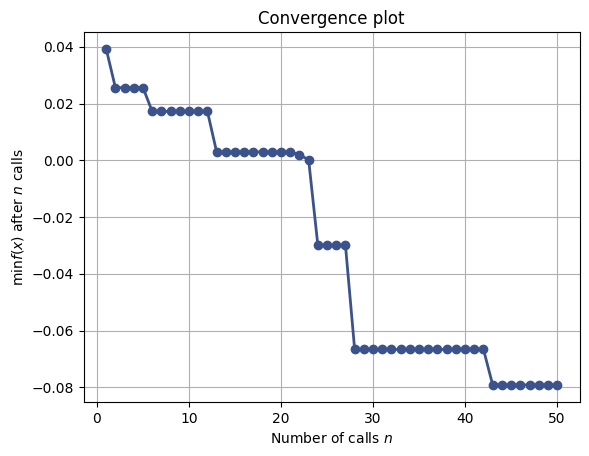

In [23]:
# plot convergence of the model
plot_convergence(result)

In [24]:
logger.info('Finished')

In [ ]:
# SITUATION-BASED ANALYSIS: Count-specific optimization
# 
# IMPORTANT: The count represents the game state AFTER the first pitch is thrown.
# 
# This answers the question: "I just threw pitch 1, the count is now X-Y. What should 
# pitch 2 be to maximize my chance of success?"
#
# Example: Count is now "0-2" (after first pitch)
#   - First pitch was thrown and resulted in a strike
#   - Now at 0 balls, 2 strikes
#   - What's the best PUTAWAY pitch to throw next?
#
# Example: Count is now "3-0" (after first pitch)
#   - First pitch was a ball
#   - Now at 3 balls, 0 strikes
#   - What should I throw to avoid walking the batter?

# We need to calculate the count AFTER the first pitch
# The 'balls' and 'strikes' columns in the data represent the count BEFORE each pitch
# So we need to look at what happened on the first pitch and update the count

sequences_df = sequences_df.with_columns([
    # Calculate the count after the first pitch based on its outcome
    pl.when(pl.col('description').is_in(['ball', 'blocked_ball', 'hit_by_pitch']))
        .then(pl.col('balls') + 1)
        .otherwise(pl.col('balls'))
        .alias('balls_after_pitch1'),
    
    pl.when(pl.col('description').is_in(['called_strike', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']))
        .then(pl.col('strikes') + 1)
        .when(pl.col('description') == 'foul')
        .then(pl.when(pl.col('strikes') < 2).then(pl.col('strikes') + 1).otherwise(pl.col('strikes')))
        .otherwise(pl.col('strikes'))
        .alias('strikes_after_pitch1')
])

# Create count label based on the NEW count (after pitch 1)
sequences_df = sequences_df.with_columns(
    count_after_pitch1 = pl.concat_str([
        pl.col('balls_after_pitch1').cast(pl.Utf8), 
        pl.lit('-'), 
        pl.col('strikes_after_pitch1').cast(pl.Utf8)
    ])
)

# Define ALL possible count situations (what the count could be after pitch 1)
all_counts = []
for balls in range(4):  # 0, 1, 2, 3
    for strikes in range(3):  # 0, 1, 2
        all_counts.append({
            'balls': balls,
            'strikes': strikes,
            'name': f'{balls}-{strikes}'
        })

situations = all_counts  # All 12 possible counts

# See how much data we have for each count AFTER pitch 1
count_distribution = sequences_df.group_by('count_after_pitch1').agg(
    pl.count().alias('total_sequences')
).sort('total_sequences', descending=True)

logger.info(f"Sequences by count (AFTER throwing first pitch):\n{count_distribution}")
print("\nData availability by count (after pitch 1):")
print(count_distribution)

count_distribution

In [ ]:
def analyze_by_situation(situation_dict, sequences_df_full, top_n=3):
    """
    Analyze pitch sequences for a specific game situation.
    
    This answers: "I just threw pitch 1, count is now X-Y, what should pitch 2 be?"
    
    Parameters:
    -----------
    situation_dict : dict
        Dictionary with 'balls', 'strikes', 'name' keys (representing count AFTER pitch 1)
    sequences_df_full : polars DataFrame
        Full sequences dataframe with 'count_after_pitch1' column
    top_n : int
        How many top pitch sequences to analyze for this situation
    
    Returns:
    --------
    polars DataFrame with optimization results for this situation
    """
    situation_name = situation_dict['name']
    logger.info(f"\n{'='*60}")
    logger.info(f"ANALYZING SITUATION: Count is now {situation_name} (after pitch 1)")
    logger.info(f"{'='*60}")
    
    # Filter sequences_df to only this count (AFTER pitch 1)
    situation_sequences = sequences_df_full.filter(
        pl.col('count_after_pitch1') == situation_name
    )
    
    logger.info(f"Total sequences where count became {situation_name} after pitch 1: {len(situation_sequences)}")
    
    if len(situation_sequences) < 50:
        logger.warning(f"Not enough data for {situation_name} (only {len(situation_sequences)} sequences)")
        return None
    
    # Find most common pitch sequences for THIS situation
    # This shows: "When count becomes X-Y after pitch 1, what pitch combos does Wheeler use?"
    situation_pitch_counts = situation_sequences.group_by('pitch_sequence').agg(
        pl.count().alias('count')
    ).sort('count', descending=True).head(top_n)
    
    logger.info(f"Top {top_n} pitch sequences when count is {situation_name}:")
    for row in situation_pitch_counts.iter_rows(named=True):
        logger.info(f"  {row['pitch_sequence']}: {row['count']} occurrences")
    
    # Get list of sequences to optimize
    sequences_to_optimize = situation_pitch_counts['pitch_sequence'].to_list()
    
    # Results dataframe for this situation
    results = pl.DataFrame({
        'situation': pl.Series([], dtype=pl.Utf8),
        'pitch_sequence': pl.Series([], dtype=pl.Utf8),
        'n_observations': pl.Series([], dtype=pl.Int64),
        'best_delta_x': pl.Series([], dtype=pl.Float64),
        'best_delta_z': pl.Series([], dtype=pl.Float64),
        'best_delta_velocity': pl.Series([], dtype=pl.Float64),
        'best_cost': pl.Series([], dtype=pl.Float64)
    })
    
    # Calculate tolerances for each sequence
    tolerance_multiplier = 3.0
    
    for seq in sequences_to_optimize:
        logger.info(f"\n  Optimizing {seq} when count is {situation_name}...")
        
        # Filter to just this sequence in this situation
        seq_data = situation_sequences.filter(pl.col('pitch_sequence') == seq)
        n_obs = len(seq_data)
        
        logger.info(f"    {n_obs} observations for {seq}")
        
        if n_obs < 20:
            logger.warning(f"    Skipping {seq} - not enough data ({n_obs} < 20)")
            continue
        
        # Calculate stats for this sequence
        stats = seq_data.select([
            pl.col('delta_plate_x').std().alias('std_x'),
            pl.col('delta_plate_z').std().alias('std_z'),
            pl.col('delta_velocity').std().alias('std_vel'),
            pl.col('delta_plate_x').mean().alias('mean_x'),
            pl.col('delta_plate_z').mean().alias('mean_z'),
            pl.col('delta_velocity').mean().alias('mean_vel'),
            pl.col('delta_plate_x').min().alias('min_x'),
            pl.col('delta_plate_z').min().alias('min_z'),
            pl.col('delta_velocity').min().alias('min_vel'),
            pl.col('delta_plate_x').max().alias('max_x'),
            pl.col('delta_plate_z').max().alias('max_z'),
            pl.col('delta_velocity').max().alias('max_vel'),
        ])
        
        # Set up tolerances
        tol_x = stats['std_x'][0] * tolerance_multiplier
        tol_z = stats['std_z'][0] * tolerance_multiplier
        tol_vel = stats['std_vel'][0] * tolerance_multiplier
        tolerances_list = [tol_x, tol_z, tol_vel]
        
        # Objective function
        def objective(params):
            return cost_function_description_based(params, seq_data, tolerances_list)
        
        # Initial guess
        x0 = [stats['mean_x'][0], stats['mean_z'][0], stats['mean_vel'][0]]
        
        try:
            # Run optimizer
            result = gp_minimize(
                objective,
                dimensions=[
                    Real(stats['min_x'][0], stats['max_x'][0], name='delta_plate_x'),
                    Real(stats['min_z'][0], stats['max_z'][0], name='delta_plate_z'),
                    Real(stats['min_vel'][0], stats['max_vel'][0], name='delta_velocity'),
                ],
                n_calls=30,  # Fewer calls for speed
                x0=x0,
                random_state=42
            )
            
            best_params = result.x
            best_cost = float(result.fun)
            
            logger.info(f"    Best: x={best_params[0]:.2f}, z={best_params[1]:.2f}, vel={best_params[2]:.2f}, cost={best_cost:.3f}")
            
            # Add to results
            row = pl.DataFrame({
                'situation': [situation_name],
                'pitch_sequence': [seq],
                'n_observations': [n_obs],
                'best_delta_x': [float(best_params[0])],
                'best_delta_z': [float(best_params[1])],
                'best_delta_velocity': [float(best_params[2])],
                'best_cost': [best_cost]
            })
            results = results.vstack(row)
            
        except Exception as e:
            logger.error(f"    Optimization failed for {seq}: {e}")
            continue
    
    return results

# Test with one situation first
test_results = analyze_by_situation(situations[0], sequences_df, top_n=3)
test_results

In [26]:
# Run optimization for ALL situations
all_results = pl.DataFrame({
    'situation': pl.Series([], dtype=pl.Utf8),
    'pitch_sequence': pl.Series([], dtype=pl.Utf8),
    'n_observations': pl.Series([], dtype=pl.Int64),
    'best_delta_x': pl.Series([], dtype=pl.Float64),
    'best_delta_z': pl.Series([], dtype=pl.Float64),
    'best_delta_velocity': pl.Series([], dtype=pl.Float64),
    'best_cost': pl.Series([], dtype=pl.Float64)
})

for situation in situations:
    logger.info(f"\nProcessing situation: {situation['name']}")
    result = analyze_by_situation(situation, sequences_df, top_n=3)
    
    if result is not None and len(result) > 0:
        all_results = all_results.vstack(result)
    else:
        logger.warning(f"No results for situation {situation['name']}")

# Display all results sorted by situation and cost
all_results = all_results.sort(['situation', 'best_cost'])
logger.info(f"\n{'='*60}")
logger.info(f"FINAL RESULTS - Best pitch locations by situation")
logger.info(f"{'='*60}")

all_results

situation,pitch_sequence,n_observations,best_delta_x,best_delta_z,best_delta_velocity,best_cost
str,str,i64,f64,f64,f64,f64
"""0-0""","""FF-FF""",763,-2.81,-2.58,2.98673,-0.2
"""0-0""","""SI-SI""",336,2.039353,2.257122,2.652357,-0.127849
"""0-0""","""FF-FC""",398,-2.689265,-2.87512,-8.888842,-0.125261
"""0-1""","""FC-FF""",146,-3.11,3.35,10.1,-0.066667
"""0-1""","""FF-FF""",321,-2.46,-2.92,1.793511,-0.054238
…,…,…,…,…,…,…
"""2-2""","""FF-FF""",119,1.966114,-2.556021,1.375856,-0.073667
"""2-2""","""FC-FF""",76,-2.203918,-2.37802,3.805429,0.07729
"""3-2""","""FF-SI""",32,-2.04,-1.27,-1.744086,-0.114286


In [ ]:
# PITCH RECOMMENDATION SYSTEM
# Given the current count (after pitch 1), recommend what pitch 2 should be

def get_pitch_recommendation(count_label, all_results_df):
    """
    Given the current count (after pitch 1), recommend what pitch 2 should be.
    
    This answers: "I just threw pitch 1, count is now X-Y, what should I throw next?"
    
    Parameters:
    -----------
    count_label : str
        The count label AFTER pitch 1 (e.g., '0-2', '3-2')
    all_results_df : polars DataFrame
        Results from situation-based optimization
    
    Returns:
    --------
    dict with recommendation details
    """
    # Filter to this situation
    situation_results = all_results_df.filter(
        pl.col('situation') == count_label
    ).sort('best_cost')  # Lower cost is better
    
    if len(situation_results) == 0:
        return {
            'count': count_label,
            'recommendation': 'No data available',
            'pitch1_type': 'N/A',
            'pitch2_type': 'N/A',
            'delta_x': 0.0,
            'delta_z': 0.0,
            'delta_velocity': 0.0,
            'expected_cost': 0.0,
            'n_observations': 0,
            'has_data': False
        }
    
    # Best sequence is the one with lowest cost
    best = situation_results.row(0, named=True)
    
    pitch1_type = best['pitch_sequence'].split('-')[0]
    pitch2_type = best['pitch_sequence'].split('-')[1]
    
    return {
        'count': count_label,
        'recommended_sequence': best['pitch_sequence'],
        'pitch1_type': pitch1_type,
        'pitch2_type': pitch2_type,
        'delta_x': best['best_delta_x'],
        'delta_z': best['best_delta_z'],
        'delta_velocity': best['best_delta_velocity'],
        'expected_cost': best['best_cost'],
        'n_observations': best['n_observations'],
        'has_data': True,
        'interpretation': f"Count is now {count_label}. Best next pitch: {pitch2_type} (previous pitch was {pitch1_type}). Location change: ({best['best_delta_x']:.2f}ft horizontal, {best['best_delta_z']:.2f}ft vertical), velocity change: {best['best_delta_velocity']:.1f} mph"
    }

# Create recommendations for all situations
recommendations = []
for situation in situations:
    rec = get_pitch_recommendation(situation['name'], all_results)
    recommendations.append(rec)
    if rec['has_data']:
        logger.info(f"\n{rec['interpretation']}")

# Display all recommendations
print("\n" + "="*80)
print("PITCH RECOMMENDATIONS BY COUNT (after pitch 1)")
print("="*80)
print("\nQuestion: I just threw pitch 1, the count is now X-Y. What should pitch 2 be?")
print("="*80)
for rec in recommendations:
    if rec['has_data']:
        print(f"\n{rec['count']} Count:")
        print(f"  Best Next Pitch: {rec['pitch2_type']} (after throwing {rec['pitch1_type']})")
        print(f"  Location Change from pitch 1 to pitch 2:")
        print(f"    - Horizontal: {rec['delta_x']:.2f} ft")
        print(f"    - Vertical: {rec['delta_z']:.2f} ft")
        print(f"  Velocity Change: {rec['delta_velocity']:.1f} mph")
        print(f"  Expected Cost (lower=better): {rec['expected_cost']:.3f}")
        print(f"  Based on {rec['n_observations']} historical sequences")
    else:
        print(f"\n{rec['count']} Count: No data available")

# Convert to dataframe for easy viewing
recommendations_df = pl.DataFrame({
    'count_after_p1': [r['count'] for r in recommendations],
    'pitch1': [r['pitch1_type'] for r in recommendations],
    'pitch2_rec': [r['pitch2_type'] for r in recommendations],
    'delta_x': [r['delta_x'] for r in recommendations],
    'delta_z': [r['delta_z'] for r in recommendations],
    'delta_vel': [r['delta_velocity'] for r in recommendations],
    'cost': [r['expected_cost'] for r in recommendations],
    'n_obs': [r['n_observations'] for r in recommendations]
})

print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(recommendations_df)

recommendations_df